In [184]:

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [185]:
# data = pd.read_csv('./data/subscriber_retention.csv')
data = pd.read_csv('./data/bloodpressure_sodium_age.csv')
data

,bloodpressure,sodium,age
0,152.069798,4.410849,73.820262
1,136.302391,2.984810,67.000786
2,143.984346,2.346063,69.893690
3,156.454474,3.671327,76.204466
4,151.154654,2.530366,74.337790
...,...,...,...
4995,131.477051,1.773670,64.493128
4996,143.359459,3.860877,68.733329
4997,144.650306,4.386089,69.645909
4998,135.537161,3.641918,66.147090


In [186]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import skfuzzy as fuzz
from skfuzzy import control as ctrl


class GenericFuzzy:

  def __init__(self,
               data:pd.DataFrame,
               c:float = 0.2,
               num_fuzzy_sets:int = 6,
               num_intervals:int = 5,
               target_consequent:int='bloodpressure',
               num_points:int= 100,
               min_support:float=0.01
               ):
    self.data = data
    self.c = c
    self.num_fuzzy_sets = num_fuzzy_sets
    self.num_intervals  = num_intervals
    self.target_consequent = target_consequent
    self.min_support = min_support

    self.apply_fuzzy_sets_to_variables()
    self.generate_rules()
    self.format_rules()

    self.num_points = num_points
    self.fuzzy_rules = []
    self.variables = {el: None for el in self.data.columns}
    self.provide_antecedent()
    self.provide_consequent()
    self.apply_membership_function()

    self.namespace = {el: self.antecedent[el] for el in self.antecedent}
    self.namespace[self.consequent.label] = self.consequent
  
  def partition(self, min, max, i):
    return  min + i*(max - min)/self.num_intervals

  def membership_function(self, min, max, i, x):
    if i == 0:
      point_1 = self.partition(min, max, i)
      point_2 = self.partition(min, max, i + 2)
      mean = point_1
      std = self.c*(point_2 - point_1)
      return np.where(point_1 <= x, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
    elif i == self.num_intervals:
      point_1 = self.partition(min, max, i - 2)
      point_2 = self.partition(min, max, i )
      mean = point_2
      std = self.c*(point_2 - point_1)
      return np.where(x <= point_2, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
    else:
      point_1 = self.partition(min, max, i - 1)
      point_2 = self.partition(min, max, i)
      point_3 = self.partition(min, max, i + 1)
      mean = point_2
      std = self.c*(point_3 - point_2)
      return np.exp(-((x - mean)**2)/(2*(std**2)))
  
  def apply_and_replace(self, min, max, x):
      max_result = -float('inf')  # Initialize with negative infinity
      max_index = -1  # Initialize index
  
      for i in range(self.num_fuzzy_sets):
          result = self.membership_function(min, max, i, x)
          if result > max_result:
              max_result = result
              max_index = i
      return max_index

  def apply_fuzzy_sets_to_variables(self, variables:list=[]):
    self.Data = self.data.copy(deep=True)
    for variable in self.Data.columns:
      self.min = self.Data[variable].min()
      self.max = self.Data[variable].max()
      self.Data[variable] = self.Data[variable].apply(
          lambda x: self.apply_and_replace(self.data[variable].min(), self.data[variable].max(), x))
    return self.Data
  
  def generate_rules(self, target_value:str = None):
    if not self.target_consequent and not target_value:
       raise ValueError('Target value is required!')
    elif target_value:
       self.target_consequent = target_value
  
    self.apply_fuzzy_sets_to_variables()
    # Encode categorical data (convert to binary format)
    self.data_encoded = pd.get_dummies(self.Data, columns=self.data.columns)

    # Apply Apriori algorithm to find frequent itemsets
    self.frequent_itemsets = apriori(self.data_encoded, min_support=self.min_support, use_colnames=True)
    # Generate association rules
    rules = association_rules(self.frequent_itemsets, metric="lift", min_threshold=1.0)

    # List of all blood pressure related items
    levels = list(np.arange(1, self.num_fuzzy_sets))
    target_items = [f'{self.target_consequent}_{level}' for level in levels]

    # Filter rules where all items in the consequents are blood pressure related
    target_only_rules = rules[rules['consequents'].apply(lambda x: all(item in target_items for item in x))]

    self.rules_with_elements = {}

    for i in range(1, len(self.data.columns)):
       self.rules_with_elements[i] = target_only_rules[
          target_only_rules['antecedents'].apply(lambda x: len(x) == i)]

    return self.rules_with_elements
  
  def transform_item(self, item):
    # Split the item into parts and handle cases with more than one underscore
    parts = item.split('_')
    if len(parts) < 2:
       return item
    if len(parts) > 2:
        # Rejoin all parts except the last as the variable name
        variable = '_'.join(parts[:-1])
        value = parts[-1]
    else:
        variable, value = parts

    # Return the transformed item as a normal text string
    return f"{variable}['{value}']"

  def transform_rule_set(self, rule_set):
      # Transform each item in the set
      return set(self.transform_item(item) for item in rule_set)
  
  def format_rules(self):
    for d in self.rules_with_elements:
      self.rules_with_elements[d]['antecedents'] = self.rules_with_elements[d]['antecedents'].apply(self.transform_rule_set)
      self.rules_with_elements[d]['consequents'] = self.rules_with_elements[d]['consequents'].apply(self.transform_rule_set)

  def provide_antecedent(self):
    self.antecedent = {
      el: ctrl.Antecedent(
            np.arange(
              self.data[el].min(), self.data[el].max(),
              (self.data[el].max() - self.data[el].min())/self.num_points), el)
      
      for el in self.data.columns if el != self.target_consequent
    }

  def provide_consequent(self):
    self.consequent = ctrl.Consequent(
      np.arange(
        self.data[self.target_consequent].min(), self.data[self.target_consequent].max(),
        (self.data[self.target_consequent].max() - self.data[self.target_consequent].min())/self.num_points),
      self.target_consequent
    )
  
  def membership_function_fuzzy_generic_control(self, variable, min, max):
    for i in range(self.num_fuzzy_sets):
      string = str(i)
      if i == 0:
        point_1 = self.partition(min, max, i)
        point_2 = self.partition(min, max, i + 2)
        variable[string] = fuzz.gaussmf(variable.universe, point_1, self.c*(point_2 - point_1))
      elif i == self.num_intervals:
        point_1 = self.partition(min, max, i - 2)
        point_2 = self.partition(min, max, i )
        variable[string] = fuzz.gaussmf(variable.universe, point_2, self.c*(point_2 - point_1))
      else:
        point_1 = self.partition(min, max, i - 1)
        point_2 = self.partition(min, max, i)
        point_3 = self.partition(min, max, i + 1)
        variable[string] = fuzz.gaussmf(variable.universe, point_2, self.c*(point_3 - point_1))
  
  def apply_membership_function(self):
    for el in self.antecedent.values():
      self.membership_function_fuzzy_generic_control(
        el, self.data[el.label].min(),
        self.data[el.label].max()
      )

    self.membership_function_fuzzy_generic_control(
      self.consequent, self.data[self.consequent.label].min(),
      self.data[self.consequent.label].max()
    )
  
  # Define the rules

  def parse_fuzzy_reference(self, reference_str, namespace):
      parts = reference_str.split('[')
      var_name = parts[0]
      # Correctly strip quotes and extra characters
      set_name = parts[1].replace("'", "").replace('"', "").replace("]", "")
      return namespace[var_name][set_name]

  def combine_conditions(self, conditions):
    combined = conditions[0]
    for cond in conditions[1:]:
        combined &= cond
    return combined

  def generate_fuzzy_rules(self, element_in_rule:int=2):
    for i in range(len(self.rules_with_elements[element_in_rule])):
      antecedents = list(self.rules_with_elements[element_in_rule].iloc[i]['antecedents'])
      consequents = list(self.rules_with_elements[element_in_rule].iloc[i]['consequents'])
      antecedent_conditions = [self.parse_fuzzy_reference(ant, self.namespace) for ant in antecedents]
      rule = ctrl.Rule(self.combine_conditions(antecedent_conditions), self.parse_fuzzy_reference(consequents[0], self.namespace))
      self.fuzzy_rules.append(rule)

In [187]:
num_fuzzy_sets = 6
num_intervals = num_fuzzy_sets-1

generic_fuzzy = GenericFuzzy(
  data=data,
  c=0.2,
  num_fuzzy_sets=num_fuzzy_sets,
  num_intervals=num_intervals,
  target_consequent='bloodpressure'
  # target_consequent='Did renew'
)

In [188]:
generic_fuzzy.rules_with_elements[2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
41,"{sodium['1'], age['1']}",{bloodpressure['1']},0.0112,0.0764,0.0104,0.928571,12.154076,0.009544,12.930400,0.928118
47,"{age['1'], sodium['2']}",{bloodpressure['1']},0.0326,0.0764,0.0320,0.981595,12.848103,0.029509,50.182267,0.953243
52,"{sodium['3'], age['1']}",{bloodpressure['1']},0.0212,0.0764,0.0190,0.896226,11.730712,0.017380,8.900145,0.934566
57,"{sodium['1'], age['2']}",{bloodpressure['2']},0.0492,0.4690,0.0452,0.918699,1.958847,0.022125,6.531300,0.514825
64,"{sodium['2'], age['2']}",{bloodpressure['2']},0.2058,0.4690,0.1978,0.961127,2.049312,0.101280,13.659975,0.644713
71,"{sodium['3'], age['2']}",{bloodpressure['2']},0.1620,0.4690,0.1554,0.959259,2.045329,0.079422,13.033636,0.609882
75,"{age['2'], sodium['4']}",{bloodpressure['2']},0.0288,0.4690,0.0242,0.840278,1.791637,0.010693,3.324522,0.454954
79,"{sodium['1'], age['3']}",{bloodpressure['3']},0.0236,0.3988,0.0164,0.694915,1.742516,0.006988,1.970600,0.436417
83,"{age['3'], sodium['2']}",{bloodpressure['3']},0.1494,0.3988,0.1258,0.842035,2.111421,0.066219,3.805902,0.618840
88,"{age['3'], sodium['3']}",{bloodpressure['3']},0.1964,0.3988,0.1858,0.946029,2.372188,0.107476,11.139215,0.719821


In [189]:
# Extracting an example
# antecedents = list(generic_fuzzy.rules_with_elements[6].iloc[0]['antecedents'])
# consequents = list(generic_fuzzy.rules_with_elements[6].iloc[0]['consequents'])

# # First antecedent as a normal text string
# antecedent_text = antecedents[0]
# print(antecedent_text)
# type(antecedent_text)

In [190]:
generic_fuzzy.generate_fuzzy_rules(element_in_rule=2)

/Users/faustinkagabo/MY_PROJECTS/GREAT_LEARNING/venv/lib/python3.10/site-packages/skfuzzy/control/term.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


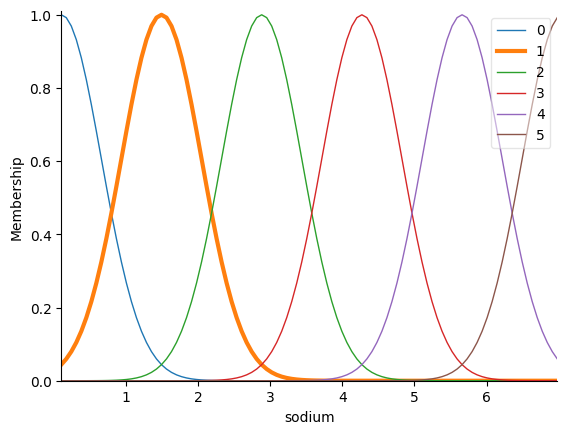

In [191]:
# generic_fuzzy.antecedent['Product need']['1'].view()
# generic_fuzzy.antecedent['Ad spend']['1'].view()
# generic_fuzzy.antecedent['Bugs faced']['1'].view()

generic_fuzzy.antecedent['sodium']['1'].view()

In [192]:
generic_fuzzy.fuzzy_rules

[IF sodium[1] AND age[1] THEN bloodpressure[1]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF age[1] AND sodium[2] THEN bloodpressure[1]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF sodium[3] AND age[1] THEN bloodpressure[1]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF sodium[1] AND age[2] THEN bloodpressure[2]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF sodium[2] AND age[2] THEN bloodpressure[2]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF sodium[3] AND age[2] THEN bloodpressure[2]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF age[2] AND sodium[4] THEN bloodpressure[2]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF sodium[1] AND age[3] THEN bloodpressure[3]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF age[3] AND sodium[2] THEN bloodpressure[3]
 	AND aggregation functio

In [193]:
generic_fuzzy_ctrl = ctrl.ControlSystem(generic_fuzzy.fuzzy_rules)
generic_fuzzy_simulation = ctrl.ControlSystemSimulation(generic_fuzzy_ctrl)

input_values = data.iloc[0]
print(input_values)
for el in generic_fuzzy_simulation._get_inputs():
  generic_fuzzy_simulation.input[el] = input_values[el]

generic_fuzzy_simulation.compute()
print(f"Estimated {generic_fuzzy.target_consequent} amount:", generic_fuzzy_simulation.output[generic_fuzzy.target_consequent])

bloodpressure    152.069798
sodium             4.410849
age               73.820262
Name: 0, dtype: float64
Estimated bloodpressure amount: 153.07960840398218


In [194]:
dff = generic_fuzzy.data[generic_fuzzy.target_consequent].copy(deep=True)
dff

0       152.069798
1       136.302391
2       143.984346
3       156.454474
4       151.154654
           ...    
4995    131.477051
4996    143.359459
4997    144.650306
4998    135.537161
4999    139.221231
Name: bloodpressure, Length: 5000, dtype: float64

In [195]:
simulation_output = np.zeros(generic_fuzzy.data.shape[0])

for i in range(len(generic_fuzzy.data)):
  input_values = generic_fuzzy.data.iloc[i]
  for el in generic_fuzzy_simulation._get_inputs():
    generic_fuzzy_simulation.input[el] = input_values[el]
  generic_fuzzy_simulation.compute()
  
  simulation_output[i] = generic_fuzzy_simulation.output[generic_fuzzy.target_consequent]

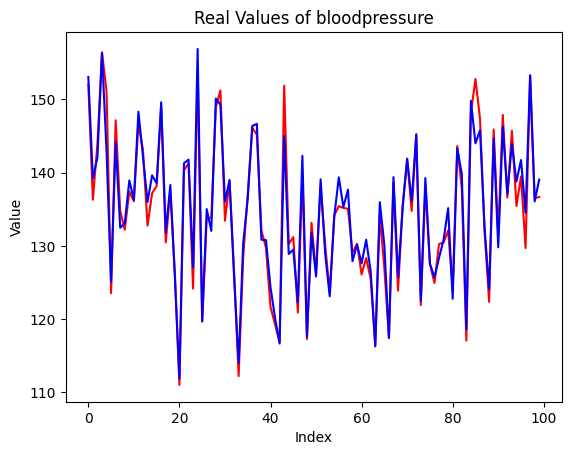

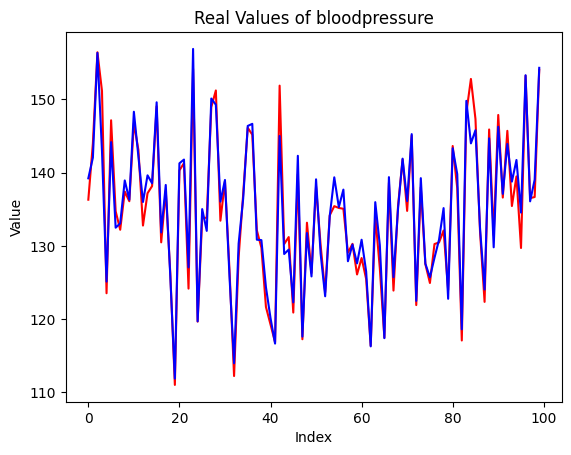

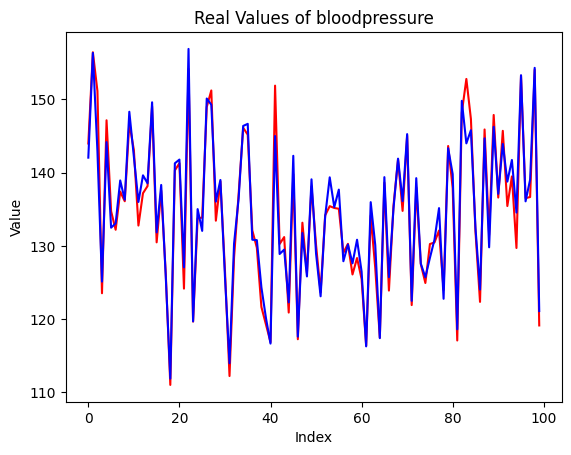

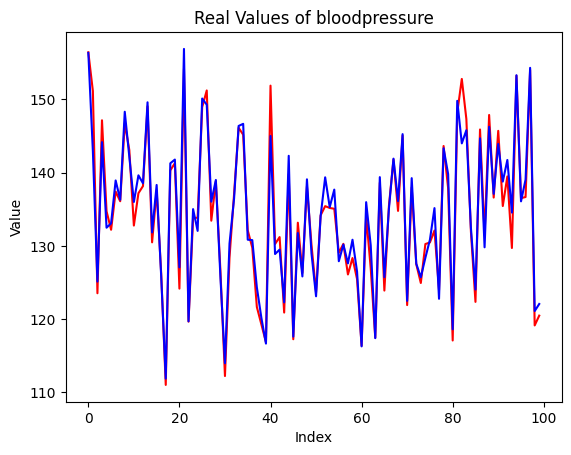

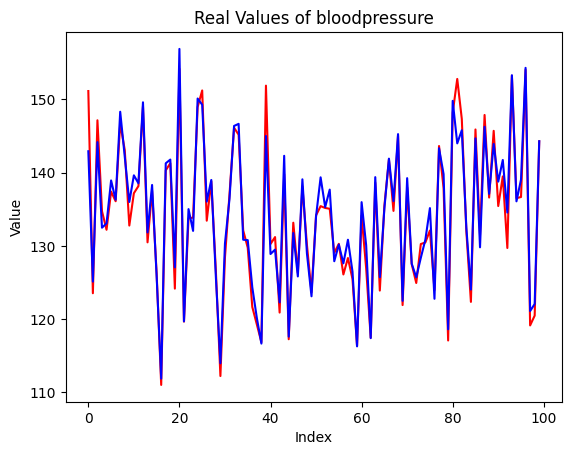

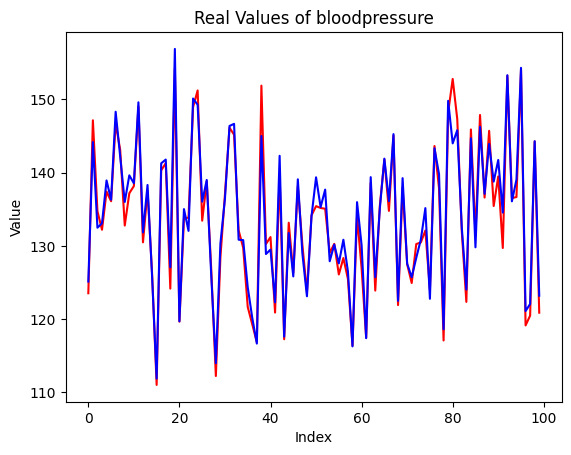

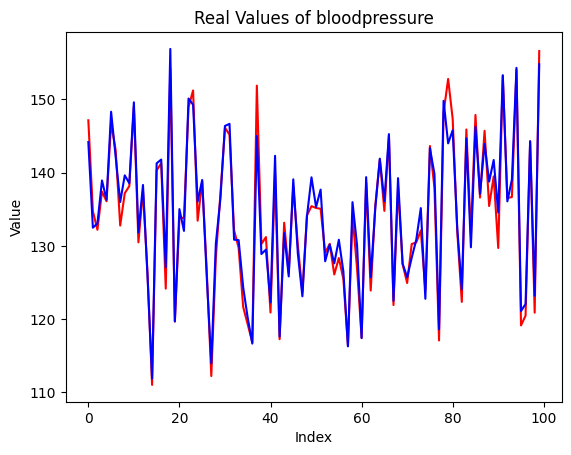

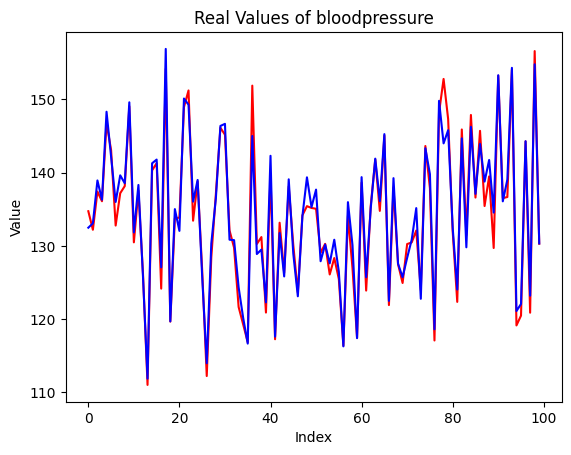

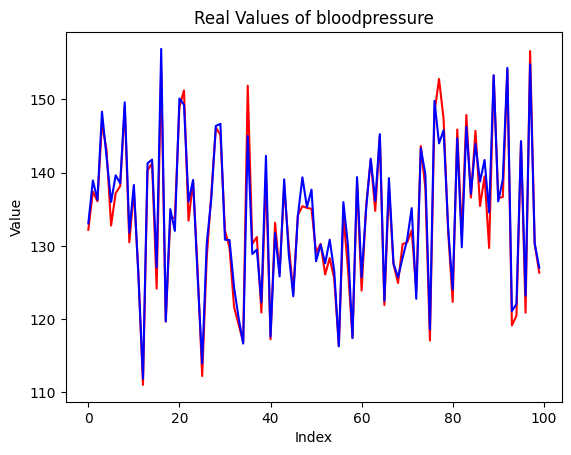

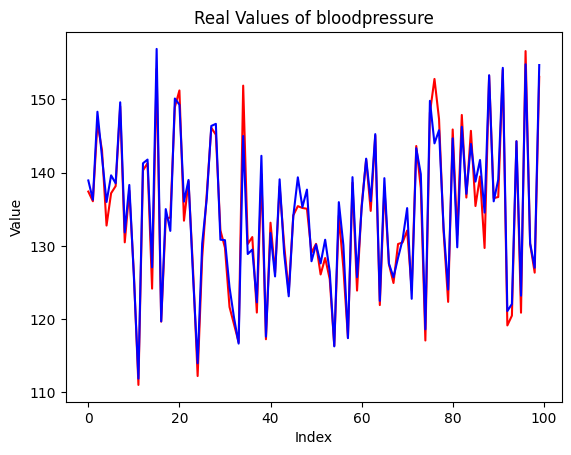

In [196]:
dff = generic_fuzzy.data[generic_fuzzy.target_consequent].copy(deep=True)
dff = dff.to_numpy()

for i in range(10):
  plt.plot(dff[i:i+100], color = 'r')
  plt.plot(simulation_output[i:i+100], color = 'b')
  plt.title(f'Real Values of {generic_fuzzy.target_consequent}')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.show()